In [39]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

import albumentations as albu

In [40]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [41]:
class PetModel(pl.LightningModule):
    
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        self.register_buffer("std", torch.tensor([127.5]).view(1, 1, 1, 1))
        self.register_buffer("mean", torch.tensor([1.0]).view(1, 1, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = image / self.std - self.mean
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)
    
    @staticmethod
    def resize_and_pad(img, dsize=(320, 320), channel=1, border_color=255):
        '''
        :param img: (H, W, C)
        :param dsize: (W, H) 目标大小
        :return:
        '''
        ih, iw = img.shape[:2]
        dw, dh = dsize

        # 计算最优目标 (nw, nh)
        max_wh_ratio = max(float(iw) / ih, float(dw) / dh) # 获取最大宽高比
        nh = dh
        nw = max_wh_ratio * dh
        nw = int(int(nw / 32.0 + 0.5) * 32) # 32倍数四舍五入

        if float(iw) / ih > float(nw) / nh:
            # 图宽了
            ratio = 1.0 * nw / iw
        else:
            # 图高了
            ratio = 1.0 * nh / ih
        
        # 保持宽高比缩放
        resized = cv2.resize(img, None, fx=ratio, fy=ratio)
        new_image = np.zeros((nh, nw), dtype=np.uint8) + border_color
        new_image[:resized.shape[0], :resized.shape[1]] = resized
        return new_image

    def preprocess(self, image):
        # image = self.resize_and_pad(image)
        image = albu.PadIfNeeded(320, 320)(image=image)['image']
        image = np.expand_dims(image, 2)
        tensor = np.transpose(image, (2, 0, 1))
        tensor = np.float32(tensor) #/ 127.5 - 1.0
        tensor = tensor[np.newaxis, ...]
        return tensor

In [42]:
model = PetModel("UNet", "timm-mobilenetv3_small_100", in_channels=1, out_classes=1)
state_dict = torch.load('qrcode-unet-mbv3-100.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

tensor(1.6279e-32) tensor(1.)


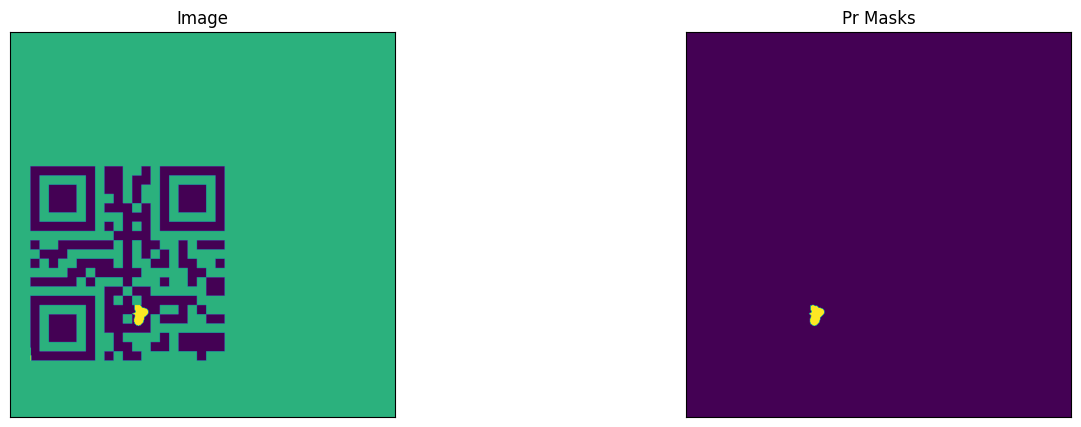

In [43]:
image = cv2.imread('../BarcodeBlemish/QRCodeDatasets/defective/000002.png', 0)

with torch.no_grad():
    model.eval()
    image_tensor = model.preprocess(image)
    logits = model(image_tensor)
    pr_masks = logits.sigmoid()
    print(pr_masks.min(), pr_masks.max())

visualize(image=image, pr_masks=pr_masks[0][0])